Alright, great job finishing Chapter 2! We've built a solid foundation in regression, where you predicted a *value* (like a house price).

Now, let's move on to **Chapter 3: Classification**. This is a different beast. Instead of predicting a number on a continuous scale, we're going to predict a **class** or a **category**. Think of it like sorting mail into different bins (bin '0', bin '1', bin '2', etc.) rather than estimating the postage cost.

---

# **Our New "Hello, World!" - The MNIST Dataset**
In programming, the first thing we always do is print "Hello, World!". In machine learning, the "Hello, World!" for classification is the **MNIST dataset**.

- **What it is:** A big collection (70,000) of small, 28x28 pixel images.

- **What's in the images:** Handwritten digits (0 through 9) written by high school students and US Census Bureau employees.

- **Why it's famous:** It's a standard benchmark. When someone invents a new classification algorithm, they test it on MNIST to see how it performs against other algorithms. It's the perfect dataset for us to start with.

---

## **Getting the Data with Scikit-Learn**

First, we need to load this dataset. Scikit-Learn has a whole module, `sklearn.datasets`, to help with this. It has three main types of functions:

1. `fetch_*`: Used to download **real-world datasets** from the internet (like `fetch_openml()`). This is what we're using.

2. `load_*`: Used to load **small, toy datasets** that come bundled *with* Scikit-Learn. These are good for quick tests.

3. `make_*`: Used to **generate fake datasets** for testing specific algorithm behaviors.

The code in the book uses `fetch_openml()` to get MNIST:

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

The important part here is `as_frame=False`. By default, this function might give you the data as a Pandas DataFrame. But for images, it's *much* easier to work with NumPy arrays. Setting `as_frame=False` tells Scikit-Learn, "Just give me the raw NumPy data."

---

## **Looking at Our Data (X and y)**
The `mnist` object that's returned is a `Bunch` object, which is like a dictionary. We can grab the two most important pieces:

`mnist.data`: The features (the images themselves). We'll call this `X`.

`mnist.target`: The labels (what digit each image represents). We'll call this `y`.

In [2]:
X, y = mnist.data, mnist.target

Let's look at their shape:

In [3]:
X.shape

(70000, 784)

`X.shape` **is** `(70000, 784)`

This is the most important concept to understand.
- **70,000:** This is easy. It's the number of images in our dataset.
- **784:** Where does this number come from?
  - Each image is $28 \times 28$ pixels.
  - To make it "machine learning friendly," the 2D image has been **"flattened"** into a single 1D row.
  - $28 \times 28 = 784$.
  - So, each row is one image, and each of the 784 columns is the **intensity of a single pixel** (from 0 for white to 255 for black).

In [4]:
y.shape

(70000,)

`y.shape` **is** `(70000,)`

This is a 1D array with 70,000 entries. It's our list of labels. The first entry in `y` ( `y[0]` ) is the correct digit for the first image in `X` ( `X[0]` ).

When you check `y[0]`, the book says it's `'5'`. This tells us the first image in our dataset is supposed to be the digit 5.

---

## **How to "See" a Flattened Image**

We can't make sense of a row of 784 numbers. To prove to ourselves that `X[0]` is really a '5', we have to reverse the flattening. We need to take that 1D array of 784 features and **reshape** it back into its original 2D $28 \times 28$ grid.

That's exactly what the `plot_digit` function does:


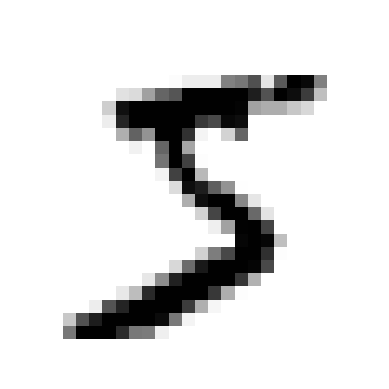

In [5]:
import matplotlib.pyplot as plt

def  plot_digit(image_data):
    # Reshape the 1D array (784, ) into a 2D array (28, 28)
    image = image_data.reshape(28, 28)

    # Use matplotlib's imshow() to display the 2D array as an image
    plt.imshow(image, cmap="binary")
    plt.axis("off")

for i in range (0, 1): # Grab the first image's data
    some_digit = X[i]
    plot_digit(some_digit)
    plt.show()

When you run this, you'll see the image of the handwritten "5".

---

## **The Golden Rule: Create a Test Set First**

This is **critical**. Before you do *any* data exploration or model training, you **must** set aside your test data.

Think of it like an exam. If you study using the *actual* exam questions (the test set), you'll get a perfect score, but you won't have *learned* anything. You'll fail when you see a new, *different* exam.

Your model is the same. It can "cheat" by memorizing the test set's answers (this is called **overfitting**). We must hide the test set and *only* use it for the final evaluation, just once.

Fortunately, the MNIST dataset from `fetch_openml()` is already organized for us:

- **Training set:** The first 60,000 images.

- **Test set:** The last 10,000 images.

So, we can easily split it:

In [6]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

### **A Note on Shuffling**
The book mentions the training set is already shuffled. This is a good thing!

1. It ensures **cross-validation** (which we'll learn about soon) works well. We don't want one "fold" of our data to *only* have 0s and 1s, and another to *only* have 8s and 9s. Shuffling mixes them up.

2. Some algorithms (like Stochastic Gradient Descent) are sensitive to order. They learn poorly if you show them 1,000 pictures of a "5" in a row. Shuffling solves this.

## **Our Mission**
That's the setup! We've moved from regression to classification, we've loaded the famous MNIST dataset, we've understood its 784 features, and we've correctly (and *very* importantly) split it into a training and a test set.

Now we're ready to start building our first classifier. Let's get to it!

---

## **Training a Binary Classifier**

Alright, let's break this down. This is a very important step in our machine learning journey.

We have a big, complicated problem: we want to identify *all* *10* *digits* (0, 1, 2, 3, 4, 5, 6, 7, 8, 9). This is called **multiclass classification**.

But as a smart learning strategy, we're going to start simpler. Instead of building a complex model to sort images into 10 different bins, let's just build a model that sorts them into *two* bins. This is a **binary classifier** ("bi" meaning two).

Our simple question will be:" **"Is this a 5?** (Yes/No).

The two classes (bins) are:

1. **"5"**: This is our *positive* class.

2. **"non-5"**: This is our *negative* class (it includes 0s, 1s, 2s, 3s, 4s, 6s, 7s, 8s, and 9s).

---

### **1. Creating the New "Answer Key"**
Our original "answer key," `y_train`, looks like this: `['5', '0', '4', '1', '9', ...]`. Our new, simple classifier doesn't understand all those digits. It only understands "Yes" or "No" (which we represent with `True` or `False`).

We need to create a new answer key. The code does this very cleverly:

In [7]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

Let's look at that first line. It goes through every single label in `y_train` and performs a check: "Is this label equal to `'5'`?"

- If `y_train[0]` is `'5'`, then `y_train_5[0]` becomes `True`.

- If `y_train[1]` is `'0'`, then `y_train_5[1]` becomes `False`.

- If `y_train[2]` is `'4'`, then `y_train_5[2]` becomes `False`.

- ...and so on.

So now, `y_train_5` is our *new* target vector (our new answer key) that looks like: `[True, False, False, ...]`. This is *exactly* what our "5-detector" needs to learn from. We do the same for our test set.

---

### **2. Choosing the Algorithm:** `SGDClassifier`
Now we need to pick a learning algorithm (a "classifier"). The book suggests a great starting point: **Stochastic Gradient Descent (SGD) Classifier.**

Let's break down that name:

- **Classifier:** It classifies things. Easy.

- **Gradient Descent:** This is the "learning" technique. Imagine you're on a foggy mountain and want to find the lowest valley. You check the slope (the "gradient") around you and take a step downhill ("descent"). You repeat this until you're at the bottom. In ML, the "valley" is the point with the *lowest* *error*.

- **Stochastic:** This is the *most* important part. "Stochastic" just means "random." Instead of checking the *entire* mountain's slope (which would mean looking at all 60,000 training images at once!), you just pick **one random training instance* at a time. You look at that single image, calculate the error for *it*, and take a small step downhill. Then you pick another random instance, and so on.

#### **Why is SGD so good?** 
It's incredibly **fast and memory-efficient**. Because it only looks at one instance at a time, you can train it on *massive* datasets (billions of instances!) that would never fit in your computer's RAM. It also makes it possible to do "online learning," where we can keep feeding the model new data as it arrives.

---

### **3. Training the Model (The** `fit` **command)**
This is where the magic happens.

In [ ]:

from sklearn.linear_model import SGDClassifier

# 1. We create an instance of the classifier
#    random_state=42 just make sure we get the same "random"
#    start each time, so our result are reproducible
sgd_clf = SGDClassifier(random_state=42)

# 2. We train the model
sgd_clf.fit(X_train, y_train_5)


The `.fit()` method is the "study" command. We're telling our `sgd_clf`:

- "Here are all the images (`X_train`)."

- "And here is the '5' or 'not-5' answer key for them (`y_train_5`)."

Now, the `SGDClassifier` goes to work. It will loop through the training data (one instance at a time, because it's *stochastic*), making a guess, checking its guess against the `y_train_5` answer, and slightly adjusting its internal parameters to get better. It does this over and over until it has a good model of what separates a "5" from a "non-5".

---

### 4. Making a Prediction (The "Pop Quiz")
The training is done. Our classifier has "studied." Now let's give it a pop quiz. We'll use that `some_digit` variable from before (which was `X[0]`, the image of the '5').

In [ ]:
some_digit = X[0]
sgd_clf.predict([some_digit])

array([ True])

- `sgd_clf.predict(...)`: We're asking our trained classifier to make a prediction.

- `[some_digit]`: We wrap `some_digit` in square brackets `[]` because the `predict` method expects a *list* of images, even if we're only sending one.

- `array([ True])`: This is the classifier's answer! It says, "I predict that this image is in the `True` class." And since `True` means "it's a 5," our classifier got this one right! 🥳

**But hold on!** Just because it got *one* right doesn't mean it's a good model. What if it gets all the *other* ones wrong?

That's why the very next step, as the book says, is to **evaluate its performance** properly. We can't just trust one example.

---
# **Peformance Measure**
---


## **Measuring Accuracy Using Cross-Validation**

Ah, this is one of the most important lessons in all of machine learning! Let's get a coffee and dive in.

So, we've trained our "5-detector" model. Our gut feeling is to ask, "What *percentage* did it get right?" That's what we call **accuracy**.

### **Part 1: The "Amazing" (but Misleading) Score**
The easiest way to check this is to use **cross-validation**, just like we did in Chapter 2.

Remember how it works: We take our *training set* (of 60,000 images) and split it into 3 "folds" (or "practice exams").

1. **Run 1:** Train the model on Folds 1 & 2, then test it on Fold 3.

2. **Run 2:** Train the model on Folds 1 & 3, then test it on Fold 2.

3. **Run 3:** Train the model on Folds 2 & 3, then test it on Fold 1.

The `cross_val_score` function does all this for us:


In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

- `sgd_clf`: Our classifier.

- `X_train`, `y_train_5`: Our training data and the "5 vs. non-5" answers.

- `cv=3`: "Use 3 folds."

- `scoring="accuracy"`: "Tell me the percentage of correct answers."

The result is `array([0.95035, 0.96035, 0.9604 ])`.

Our first reaction is: **"WOW! 95-96% accuracy! This is an A+! My model is amazing!"**

...But hold on. This is a classic trap.

---

### **Part 2: The "Gotcha!" - Skewed Datasets**
Before we celebrate, let's create the "dumbest possible classifier" as a baseline.

What if we made a model that **always guesses "not a 5"**, no matter what image it sees? It doesn't even *look* at the image. It just says "False, False, False" for every single one.

That's what the `DummyClassifier` does:

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

,strategy,'prior'
,random_state,None
,constant,None


Now, let's test this dumb model's accuracy:

In [ ]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

It gets **over 90% accuracy!**

How is this possible?

Think about our dataset. We have 60,000 images. But how many of them are *actually* 5s? As it turns out, only about 10% of them are 5s. The other 90% are "non-5s" (0s, 1s, 2s, 3s, 4s, 6s, 7s, 8s, and 9s).

This is a **skewed dataset**: one class ("non-5") is *way* more common than the other ("5").

So, if our dumb classifier *always* guesses "non-5", it will be *correct 90% of the time* just by pure chance.

**This is the most important lesson of this section:** Our "smart" model, which gets 95% accuracy, is only slightly better than a "dumb" model that always guesses "no." This tells us that **accuracy is a very poor and misleading performance measure** for skewed datasets. We need a better way to judge our model.

---

### **Part 3: The "Under the Hood" (Manual Cross-Validation)**
The book then shows you a block of code that does the *exact same thing* as `cross_val_score`. Why? Because sometimes you need more control, and it's crucial to understand what's happening.

In [ ]:
from sklearn.model_selection import StratifiedKFold
'''
This is a smarter way to split our data. The "Stratified" part is key. 
It means "When you make the 3 folds, please make sure each fold has 
the same ratio of 5s to non-5s." This prevents a fold from randomly 
having zero 5s, which would make the test useless.
'''
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    '''
    This is our loop. It will run 3 times (for 3 folds). 
    In each loop, it gives us two lists:

    -> train_index: The indexes of the images to train on (e.g., 40,000 images).

    -> test_index: The indexes of the images to test on (e.g., 20,000 images).
    '''
    clone_clf = clone(sgd_clf)
    '''
    This is critical. For each fold, we need a fresh, untrained classifier. 
    We clone our original sgd_clf to get a blank copy. 
    (We can't just keep re-training the same one, because it would have 
    already "learned" from the other folds).
    '''
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds) # We train our fresh clone using only the training data for this specific fold.
    y_pred = clone_clf.predict(X_test_fold) # We make our predictions on the hold-out test data for this fold.
    n_correct = sum(y_pred == y_test_fold)
    '''
    We compare our predictions (y_pred) to the real answers (y_test_fold) 
    and sum up all the True values (the ones we got right).
    '''
    print(n_correct/len(y_pred)) # We print the number correct divided by the total number. This is just the accuracy for that one fold.

0.95035
0.96035
0.9604


After seeing the result we can conclude that  `0.95035`, `0.96035`, and `0.9604`—the *exact same numbers* `cross_val_score` gave us.

**Key Takeaways:**
1. We can measure accuracy with `cross_val_score`.

2. Our "5-detector" got ~95% accuracy, which *looked* great.

3. A "dumb" classifier got ~91% accuracy, which proves our dataset is *skewed* (90% "non-5s").

4. **Therefore, accuracy is a misleading metric for this problem.**

This is why the book says we need a much better tool: the **Confusion Matrix**.

---

## **Confusion Matrices**

Hello again! This is another *fantastic* section. We've just discovered that **accuracy is a trap** for skewed datasets, and now we're going to learn about the *right* way to measure performance.

The new tool we'll use is called the Confusion Matrix.

---

### **1. The "Clean Predictions" Problem**

To build a confusion matrix, we need a set of predictions to compare against the real answers.

- We can't use our **test set**. That's locked in a vault until the very end.

- We can't just `fit` our model on `X_train` and then `predict` on `X_train`. The model would be "cheating" by making predictions on the exact same data it just studied.

We need "clean" predictions. This means we need a prediction for *every* image in our training set, but each prediction must be made by a model that **never saw that specific image during training.**

How do we do that? With `cross_val_predict`.

#### `cross_val_score` **vs.** `cross_val_predict`
This is a key difference:

- `cross_val_score()`: Does K-fold cross-validation and gives you back the **evaluation scores** (e.g., `[0.95, 0.96, 0.96]`).

- `cross_val_predict()`: Does K-fold cross-validation but gives you back the *predictions* for each instance.

Think of it like this: With 3 folds (A, B, C):

1. A model is trained on B+C, and it makes predictions for **A**.

2. A *new* model is trained on A+C, and it makes predictions for **B**.

3. A *new* model is trained on A+B, and it makes predictions for **C**.

You then stitch together the predictions for A, B, and C, giving you a full, "clean" set of predictions for your entire training set.

In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Now, `y_train_pred` contains a `True` or `False` guess for all 60,000 images, and we can trust these predictions are "fair."

---

### **2. The Confusion Matrix: A Report Card of Mistakes**
Now we can compare our "clean" predictions (`y_train_pred`) with the *real* answers (`y_train_5`). The `confusion_matrix` function gives us a 2x2 grid that shows us *exactly* what kinds of correct guesses and what kinds of mistakes our model made.



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

<img src="https://maxbox4.wordpress.com/wp-content/uploads/2021/05/confusiondetectmnist-1.png" alt="Figure 3.3 of chapter 3" width="600">


The image is the perfect visual for this.

- **Rows = Actual Class** (The ground truth)

- **Columns = Predicted Class** (The model's guess)

Here's the result : `array([[53892, 687]`, `[ 1891, 3530]])`

Let's break this down:

**Top Row: The "Actual: Not-5" Class (Negative)**
- `53,892` **True Negatives (TN):** These were **Not-5s**, and our model correctly predicted **"Not-5"**. This is good! (Top-left in our image).

- `687` **False Positives (FP):** These were **Not-5s**, but our model *incorrectly* predicted "5". This is a mistake (a "false alarm"). (Top-right in our image).

**Bottom Row: The "Actual: 5" Class (Positive)**
- `1,891` **False Negatives (FN):** These were *actual* **5s**, but our model incorrectly predicted "Not-5". This is also a mistake (the model "missed" it). (Bottom-left in your image).

- `3,530` **True Positives (TP):** These were *actual* **5s**, and our model correctly predicted **"5"**. This is great! (Bottom-right in your image).

A "perfect" classifier would have zeros in the FP and FN cells. We have 687 + 1,891 = 2,578 mistakes, and this matrix tells us exactly what kind they were.

---

### **3. Beyond the Matrix: Precision and Recall**
The 2x2 matrix is awesome, but it's still four numbers. We often want a single, concise metric to summarize performance. This is where **Precision** and **Recall** come in.

#### **Precision: The "How Trustworthy?" Metric**
- **Question:** "Of all the times my model *predicted* '5', what percentage was it *actually* right?"

- **Formula:** $Precision = \frac{TP}{TP + FP}$​
 
- **From our numbers:** $3530 / (3530 + 687)$

- **Analogy:** Think of a **spam filter**. We want *high precision*. When the filter *predicts* an email is spam (a "positive" prediction), we want it to be *very* sure, so it doesn't accidentally put an important email (a False Positive) in your spam folder.

#### **Recall: The "How Thorough?" Metric**
- **Question:** "Of all the *actual* 5s in the dataset, what percentage did my model *find*?"

- **Formula:** $Recall = \frac{TP}{TP + FN}$ 

- **From our numbers:** $3530 / (3530 + 1891)$

- **Analogy:** Think of a **medical test for a tumor**. We want *high recall*. We *must* find all the real tumors (True Positives) and avoid missing any (False Negatives). We'd rather have a few false alarms (low precision) than miss a single real case (low recall).

**In Summary:**

- The **Confusion Matrix** gives us the full picture of our model's mistakes.

- **Precision** measures the *quality* of our positive predictions (avoids FPs).

- **Recall** measures the *quantity* of our positive predictions (avoids FNs).

These two metrics are *much* more informative than simple accuracy, especially for skewed datasets. We'll almost always look at them together.

---

## **Precision and Recall**

Alright, we've just learned about the confusion matrix, which gives us the raw numbers for our model's performance. Now we need to turn those raw numbers into meaningful "grades."

This is where **Precision** and **Recall** come in.

---

### **1. Calculating Our "Grades"**
We *could* do the math ourselves using the confusion matrix numbers, but Scikit-Learn gives us handy functions to do it for us: precision_score and recall_score.


In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 3530 / (687 + 3530)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred) # == 3530 / (1891 + 3530)

0.6511713705958311

When we run them on our "5-detector" (using the clean `y_train_pred` predictions), we get these scores:

- **Precision: 83.7%**

- **Recall: 65.1%**

Let's translate this. That 95% accuracy we saw earlier? It was a lie. Here's the truth:

1. **Precision (83.7%):** This is our "trustworthiness" grade. When our model *claims* an image is a 5 (a positive prediction), it's only right 83.7% of the time. The other 16.3% of the time, it's a "false alarm" (a False Positive).

2. **Recall (65.1%):** This is our "thoroughness" grade. Of *all* the real 5s in the training set, our model only *found* 65.1% of them. It completely *missed* the other ~35% (those are the False Negatives).

So, our 5-detector is actually not that great. It's overconfident (it makes a lot of false claims) and it's not very observant (it misses a lot of the real 5s).

---

### **2. The F1-Score: The "GPA"**

Often, you'll have two different models.

- Model A: 90% precision, 50% recall

- Model B: 50% precision, 90% recall

Which one is "better"? It's hard to compare. We need a single number, like a **GPA**, that summarizes both grades. This is the **F1-Score**.

#### **The F1 Score Formula**
**1. The Most common Formula:**

This is the easiest one to remember and use if you already have your precision and recall scores:

   $$F_1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$$

Think of it this way: it's like a balanced average, but it *heavily punishes* low scores.
- If you have 100% precision (1.0) and 0% recall (0.0), a simple average would be 50%.
- The F1 score would be $2 \times \frac{1.0 \times 0.0}{1.0 + 0.0} = 0$. This is a much truer reflection of that model's performance—it's useless!

**2. The "Definition" Formula (Harmonic Mean)**

This formula, also in your book, shows *why* it's called the harmonic mean. It looks a bit more complex, but it's the formal definition:

$$F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}$$

(If you do the algebra, you'll see this is exactly the same as the first formula).

**3. The Raw Number Formula:**

This formula lets you calculate the F1 score directly from your confusion matrix values: **True Positives (TP), False Positives (FP),** and **False Negatives (FN).**

$$F_1 = \frac{TP}{TP + \frac{FN + FP}{2}}$$

This is just plugging the formulas for precision ($TP / (TP + FP)$) and recall ($TP / (TP + FN)$) into the first equation.

In [ ]:
from sklearn .metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

The F1-Score is the **harmonic mean** of precision and recall.

Now, why a *harmonic* mean? Why not a simple average?

A simple average is too forgiving. If a model had 100% precision but 0% recall, a simple average would be 50%. That's a "C" grade, which is misleading! That model is *terrible*—it finds nothing!

The harmonic mean gives much more weight to *low* values. To get a high F1-score, **both** precision and recall *must* be high.

- A 100% and 0% would give you an F1-score of **0%**.

- A 50% and 50% would give you an F1-score of **50%**.

- A 90% and 90% would give you an F1-score of **90%**.

Our model's F1-score is **73.2%**. This confirms our feeling: it's a C/B- student. It's a single, balanced number that tells us the model is "okay," but not great.

---

### **3. Context is King: Do You Want a "Specialist" or a "Net"?**

So, is a balanced F1-score always what we want? **Absolutely not**.

This is the most important lesson. The "best" metric depends *entirely* on your project's goal. You must choose between prioritizing Precision or Recall.

#### **Scenario 1: Prioritize PRECISION (The "Safe for Kids" Filter 🛡️)**

- **Your Goal:** You're building a classifier to find kid-safe videos.

- **A "positive" prediction is:** "This video is safe for kids."

- **What's a False Positive (FP)?** A *bad* video is incorrectly labeled "safe."

- **What's a False Negative (FN)?** A *good* video is incorrectly labeled "bad."

**Which mistake is worse?** The **False Positive** is a *catastrophe*. You let a bad video through. The False Negative is just an annoyance (a kid misses a good video).

**Your Strategy:** You need *extremely high precision*. You'd rather block 100 good videos (low recall) than let one bad video slip through.

#### **Scenario 2: Prioritize RECALL (The "Shoplifter" Detector 🚨)**

- **Your Goal:** You're building a classifier to detect shoplifters on camera.

- **A "positive" prediction is:** "That person is shoplifting."

- **What's a False Positive (FP)?** An *innocent* person is flagged.

- **What's a False Negative (FN)?** A real *shoplifter* is *not* flagged.

**Which mistake is worse?** The **False Negative** is a *catastrophe*. You just lost merchandise! The False Positive is just an annoyance (a security guard has to check a false alert).

**Your Strategy:** You need *extremely high recall*. You want to *find every single shoplifter*. You are perfectly fine with 10 false alarms (low precision) if it means you catch almost all the real thieves (high recall).

---

### **4. The Precision/Recall Trade-off**

This leads us to the final, fundamental concept: **we can't have it both ways**.

- If we want **higher precision**, we have to be *stricter*. we tell our model, "Don't flag it unless you're 99% sure!" This will give us fewer FPs (high precision) but we will *miss* more real cases (low recall).

- If we want **higher recall**, we have to be *more lenient*. we tell our model, "Flag it if you're even 30% sure!" This will help us *find* almost all the real cases (high recall) but we'll get a *ton* of false alarms (low precision).

This is the **Precision/Recall Trade-off.** Our job as an engineer isn't to get 100% on both; it's to decide where on this curve is the right balance for *our* specific problem.